In [ ]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/cv images/cv6.zip" -d "/content/"

Archive:  /content/drive/MyDrive/cv images/cv6.zip
  inflating: /content/fingerprint2.jpg  
  inflating: /content/building.jpg   
  inflating: /content/fingerprint3.png  
  inflating: /content/fingerprint1.jpg  
  inflating: /content/checkerboard.png  
  inflating: /content/notch1.jpg     
  inflating: /content/notch2.png     
  inflating: /content/bookpage.jpg   
  inflating: /content/fingerprint4.png  
  inflating: /content/notch3.jpg     
  inflating: /content/fingerprint5.png  


#1. Building .jpg

## Sobel Filter

Sobel filter horizontal = 
```
[[-1, 0, 1],
 [-2, 0, 2],
 [-1, 0, 1]]
```
Sobel filter vertical = 
```
[[-1, -2, -1],
 [0, 0, 0],
 [1, 2, 1]]
```


Threshold Function

In [ ]:
def apply_threshold(img, threshold = 30):
    h, w = img.shape
    output = np.zeros(img.shape)
    print('threshold: ', threshold)
    for i in range(h):
        for j in range(w):
            if img[i,j] > threshold:
                output[i,j] = 255
    return output

In [ ]:
def apply_sobel(img):
    h,w = img.shape
    smooth_img = cv2.GaussianBlur(img,(5,5),0)
    sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    sobel_x = cv2.filter2D(smooth_img, -1, sobel_filter_x)
    sobel_y = cv2.filter2D(smooth_img, -1, sobel_filter_y)
    sobel_xt = apply_threshold(sobel_x)
    sobel_yt = apply_threshold(sobel_y)
    fig, axs = plt.subplots(2,3, figsize = (17,8))
    axs[0,0].imshow(img, cmap = 'gray')
    axs[0,0].set_title("Original Image")

    axs[0,1].imshow(sobel_x, cmap = 'gray')
    axs[0,1].set_title("After Horizontal Sobel")

    axs[0,2].imshow(sobel_xt, cmap = 'gray')
    axs[0,2].set_title("After Thresholding previous image")
    
    
    axs[1,0].imshow(img, cmap = 'gray')
    axs[1,0].set_title("Original Image")

    axs[1,1].imshow(sobel_y, cmap = 'gray')
    axs[1,1].set_title("After Vertical Sobel")

    axs[1,2].imshow(sobel_yt, cmap = 'gray')
    axs[1,2].set_title("After Thresholding previous image")

    plt.suptitle("Sobel Filter on Gaussian Smoothing")
    plt.show()
    return sobel_x, sobel_y

## LoG 

In [ ]:
def zero_crossing(img):
    h, w = img.shape
    out = np.zeros(img.shape)
    for i in range(h-1):
        for j in range(w-1):
            nbd = [img[i-1,j], img[i+1,j], img[i-1,j-1], img[i,j-1], img[i+1,j-1], img[i-1,j-1], img[i,j+1], img[i+1,j+1]]
            ma = max(nbd)
            mi = min(nbd)
            pos = 0
            neg = 0
            for pix in nbd:
                if pix<0:
                    neg += 1
                elif pix>0:
                    pos += 1
            if neg > 0 and pos > 0:
                if img[i,j] > 0:
                    out[i,j] = img[i,j] + abs(mi)
                elif img[i,j] < 0:
                    out[i,j] = abs(img[i,j]) + ma
    return out

In [ ]:
def apply_LoG(img):
    smooth_img = cv2.GaussianBlur(img, (3,3), 1.5)
    log_img = cv2.Laplacian(smooth_img, cv2.CV_64F)
    zero_crossing_img = zero_crossing(log_img)
    zero_crossing_t_img = apply_threshold(zero_crossing_img)
    
    fig, axs = plt.subplots(2,2, figsize = (17,8))
    axs[0,0].imshow(img, cmap = 'gray')
    axs[0,0].set_title("Original Image")

    axs[0,1].imshow(log_img, cmap = 'gray')
    axs[0,1].set_title("Laplacian of Gaussian")
    
    axs[1,0].imshow(zero_crossing_img, cmap = 'gray')
    axs[1,0].set_title("Zero Crossing on LoG Image")

    axs[1,1].imshow(zero_crossing_t_img, cmap = 'gray')
    axs[1,1].set_title("After thresholding")

    plt.suptitle("laplacian of Gaussian")
    plt.show()
    return log_img, zero_crossing_img, zero_crossing_t_img

## Canny Edge Detector

In [ ]:
def apply_canny_detector(img):
    smooth_img =  cv2.GaussianBlur(img, (3,3), 0.5)
    canny = cv2.Canny(smooth_img, 100,200)
    canny_t = apply_threshold(canny)
    fig, axs = plt.subplots(1,3, figsize = (17,8))
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title("Original Image")

    axs[1].imshow(canny, cmap = 'gray')
    axs[1].set_title("Canny edge detector")
    
    axs[2].imshow(canny_t, cmap = 'gray')
    axs[2].set_title('After Thresholding Canny')

    plt.suptitle("laplacian of Gaussian")
    plt.show()
    return canny, canny_t

## Hough Transform

In [ ]:
def apply_hough(img):
    canny = cv2.Canny(img,50,200)
    lines = cv2.HoughLinesP(canny,2, np.pi/180, threshold = 200,minLineLength=100, maxLineGap=150)
    out = img.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(out, (x1, y1), (x2, y2), (255, 0, 0), 3)
    fig, axs = plt.subplots(1,2, figsize = (17,8))
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title("Original Image")

    axs[1].imshow(out, cmap = 'gray')
    axs[1].set_title("Hough Transform")
    return out

## Apply on 'building.jpg'

In [ ]:
img = cv2.imread('building.jpg',0)
#cv2_imshow(img)
print('shape of the image is: ', img.shape)

shape of the image is:  (420, 560)


threshold:  30
threshold:  30


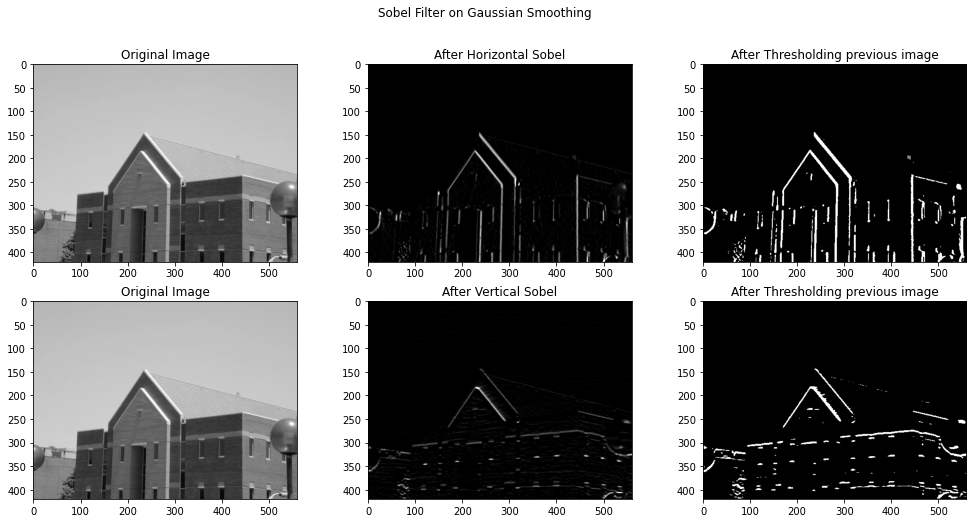

In [ ]:
_ = apply_sobel(img)

threshold:  30


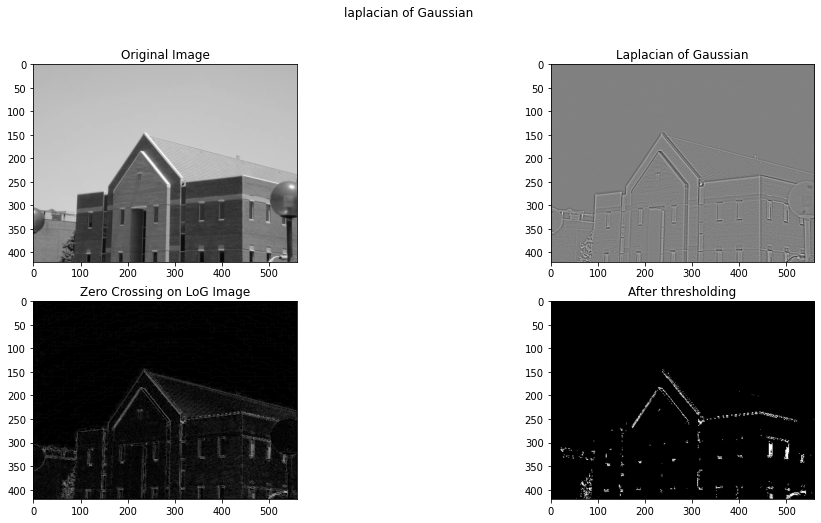

In [ ]:
_ = apply_LoG(img)

threshold:  30


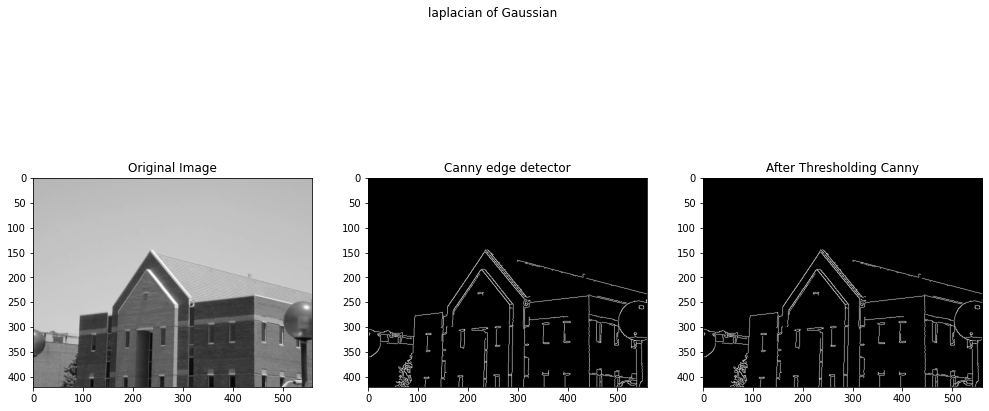

In [ ]:
_ = apply_canny_detector(img)

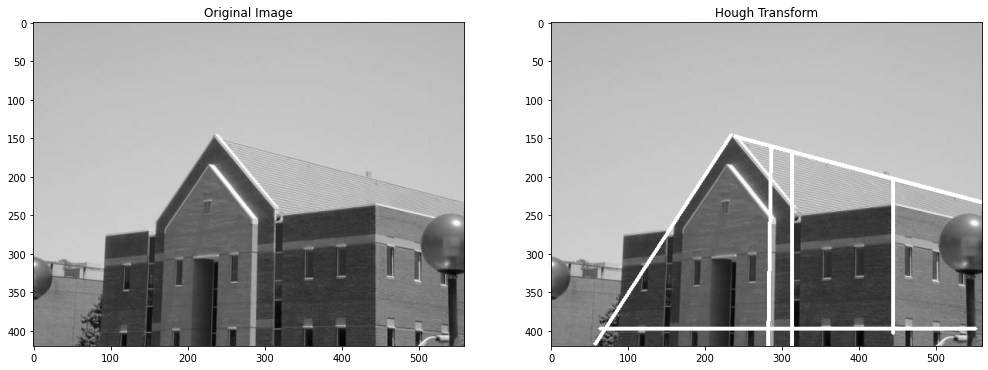

In [ ]:
_ = apply_hough(img)

## apply on 'objects.png'

In [ ]:
img = cv2.imread('objects.png',0)
#cv2_imshow(img)
print('shape of the image is: ', img.shape)

shape of the image is:  (418, 489)


threshold:  30
threshold:  30


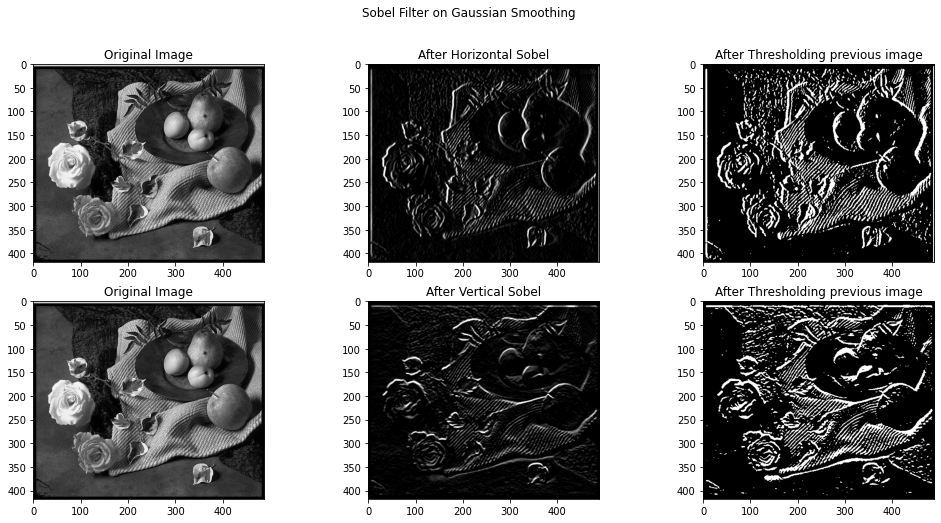

In [ ]:
_ = apply_sobel(img)

threshold:  30


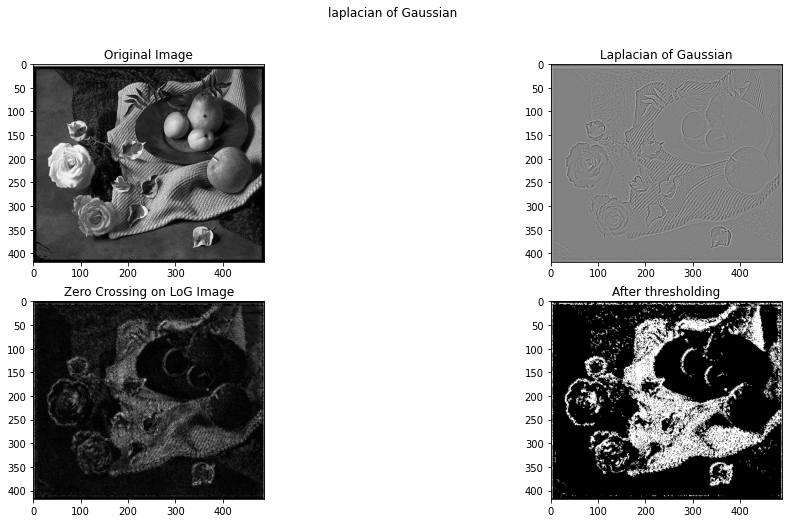

In [ ]:
_ = apply_LoG(img)

threshold:  30


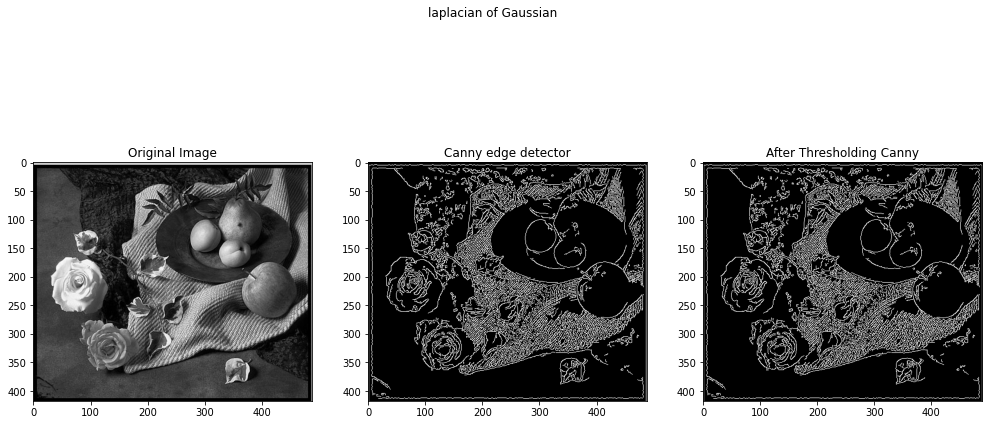

In [ ]:
_ = apply_canny_detector(img)

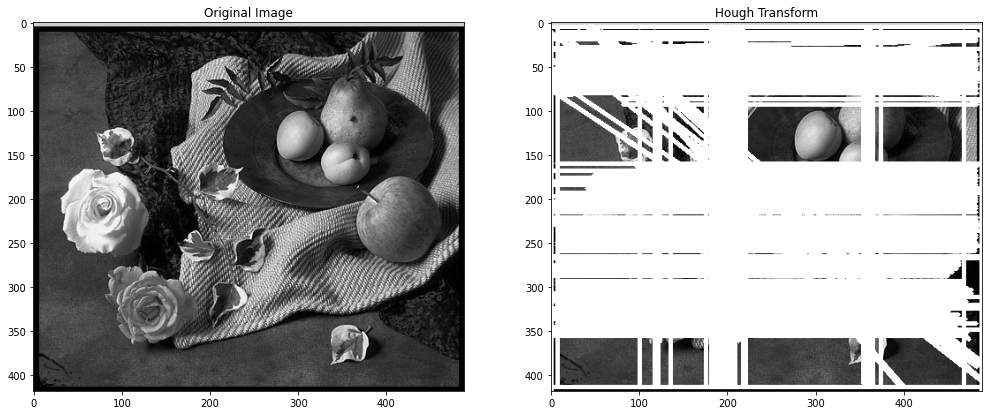

In [ ]:
_ = apply_hough(img)

#2.

##a.

### Gaussian Noise

In [ ]:
def add_gaussian_noise(img):
    h, w = img.shape
    mean = 0
    var = 1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (h,w))
    noise_img = gauss + img
    return noise_img


In [ ]:
gauss = np.random.normal(0, 1, (200,200))

### Salt & Paper noise

In [ ]:
def add_sp_noise(img):
    h,w = img.shape
    sp = 0.5
    a = 0.004
    noise_img = img.copy()
    num_salt = np.ceil(a * img.size * sp)
    coordinates = [np.random.randint(0, i-1, int(num_salt)) for i in  img.shape]
    noise_img[coordinates] = 1

    num_pepper = np.ceil(a * img.size * (1 - sp))
    coordinates = [np.random.randint(0, i-1, int(num_pepper)) for i in  img.shape]
    noise_img[coordinates] = 0
    return noise_img

### Periodic Noise

In [ ]:
def add_periodic_noise(img, A = 0.5, omega = np.pi):
    h, w = img.shape
    noise_img = np.zeros(img.shape)
    for i in range(h):
        for j in range(w):
            noise_img[i,j] = img[i,j] + A*np.sin(omega*i) + A*np.sin(omega*j)
    
    return noise_img

Apply on 'checkerboard.png'

In [ ]:
img = cv2.imread("checkerboard.png", 0)
print('shape of the image :', img.shape)

shape of the image : (200, 200)


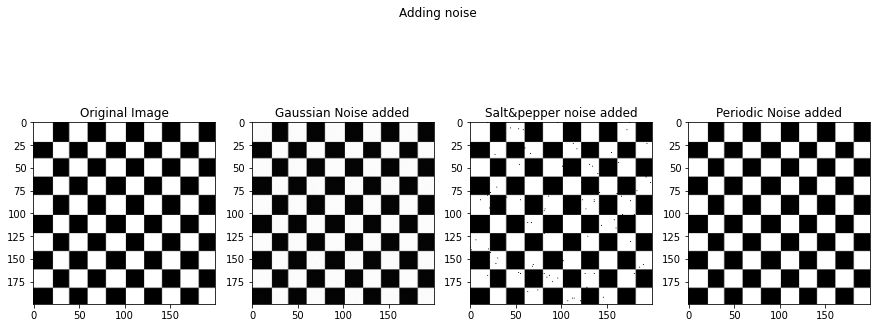

In [ ]:
gauss_noise = add_gaussian_noise(img)
sp_noise = add_sp_noise(img)
periodic_noise = add_periodic_noise(img)

fig, axs = plt.subplots(1,4, figsize = (15,6))
axs[0].imshow(img, cmap = 'gray')
axs[0].set_title("Original Image")

axs[1].imshow(gauss_noise, cmap = 'gray')
axs[1].set_title("Gaussian Noise added")

axs[2].imshow(sp_noise, cmap = 'gray')
axs[2].set_title('Salt&pepper noise added')

axs[3].imshow(periodic_noise, cmap = 'gray')
axs[3].set_title('Periodic Noise added')

plt.suptitle("Adding noise")
plt.show()

##b.

In [ ]:
def get_fshift(img):
    img = np.asarray(img)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    dft = 20 * np.log(np.abs(fshift))
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum, phase_spectrum = cv2.cartToPolar(dft_shift[:,:,0],dft_shift[:,:,1])
    magnitude_spectrum_new = 20*np.log(1 + magnitude_spectrum)
    result = np.where(magnitude_spectrum_new == np.amax(magnitude_spectrum_new))
    result  = magnitude_spectrum_new.argsort(axis=-1, kind=None, order=None)[-9:][::-1]
    
    points =[]
    for i in range(9):
        highest, high_index = -1, 0.1
        for ind_i,i in enumerate(magnitude_spectrum_new):
            for ind_j,j in enumerate(i):
                if j>highest and not((ind_i, ind_j) in points):
                    highest= j
                    high_index=(ind_i, ind_j)
        points.append(high_index)

    return points[1:]

def denoise_ideal(img):
    img = np.asarray(img)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    dft, d0 = 20 * np.log(np.abs(fshift)), 0.5
    M, N  = fshift.shape
    
    points = get_fshift(img.copy())
    for u in range(M):
        for v in range(N):
            for d in range(len(points)):
                u0, v0 = points[d][0], points[d][1]
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 1)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 1)
                if d1 <= d0 or d2 <= d0:
                    fshift[u][v] *= 0.0
    f_ishift = np.fft.ifftshift(fshift)
    return np.abs(np.fft.ifft2(f_ishift))

In [ ]:
def gauss_denoise(img):
    dst = cv2.GaussianBlur(img, (3,3), 0.5)
    return dst

def box_denoise(img):
    box = np.ones((5,5))
    dst = cv2.filter2D(img, -1, box)
    return dst

def median_denoise(img):
    dst = cv2.medianBlur(img,5)
    return dst

def notch_denoise(img):
    dst = denoise_ideal(img)
    return dst


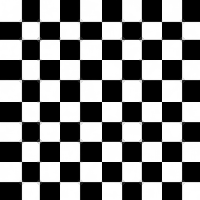

In [ ]:
dst = cv2.medianBlur(np.float32(gauss_noise),5)
cv2_imshow(dst)

Text(0.5, 1.0, 'median denoise on periodic noise')

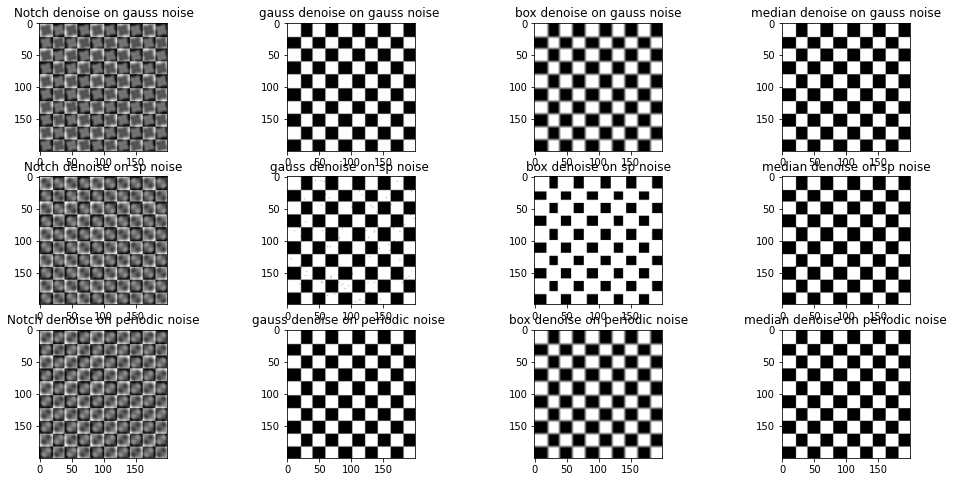

In [ ]:
fig, axs = plt.subplots(3,4, figsize = (17,8))
axs[0,0].imshow(notch_denoise(gauss_noise), cmap = 'gray')
axs[0,0].set_title("Notch denoise on gauss noise")

axs[0,1].imshow(gauss_denoise(gauss_noise), cmap = 'gray')
axs[0,1].set_title("gauss denoise on gauss noise ")

axs[0,2].imshow(box_denoise(gauss_noise), cmap = 'gray')
axs[0,2].set_title("box denoise on gauss noise")

axs[0,3].imshow(median_denoise(np.float32(gauss_noise)), cmap = 'gray')
axs[0,3].set_title("median denoise on gauss noise")

axs[1,0].imshow(notch_denoise(sp_noise), cmap = 'gray')
axs[1,0].set_title("Notch denoise on sp noise")

axs[1,1].imshow(gauss_denoise(sp_noise), cmap = 'gray')
axs[1,1].set_title("gauss denoise on sp noise ")

axs[1,2].imshow(box_denoise(sp_noise), cmap = 'gray')
axs[1,2].set_title("box denoise on sp noise")

axs[1,3].imshow(median_denoise(np.float32(sp_noise)), cmap = 'gray')
axs[1,3].set_title("median denoise on sp noise")

axs[2,0].imshow(notch_denoise(periodic_noise), cmap = 'gray')
axs[2,0].set_title("Notch denoise on periodic noise")

axs[2,1].imshow(gauss_denoise(periodic_noise), cmap = 'gray')
axs[2,1].set_title("gauss denoise on periodic noise ")

axs[2,2].imshow(box_denoise(periodic_noise), cmap = 'gray')
axs[2,2].set_title("box denoise on periodic noise")

axs[2,3].imshow(median_denoise(np.float32(periodic_noise)), cmap = 'gray')
axs[2,3].set_title("median denoise on periodic noise")

##c.

In [ ]:
def butter_notch(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    dft, d0, eps = 20 * np.log(np.abs(fshift)), 0.5, 0.000001
    points = get_fshift(img.copy())
    
    M, N = fshift.shape
    for u in range(M):
        for v in range(N):
            for d in range(len(points)):
                u0, v0 = points[d][0], points[d][1]
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5) 
                fshift[u][v] *= (1.0 / (1 + pow((d0 * d0) / (d1 * d2 + eps), 1))) 
    f_ishift = np.fft.ifftshift(fshift)
    return np.abs(np.fft.ifft2(f_ishift))


In [ ]:
def gauss_notch(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    dft, d0 = 20 * np.log(np.abs(fshift)), 0.5
    points = get_fshift(img.copy())

    M, N = fshift.shape
    for u in range(M):
        for v in range(N):
            for d in range(len(points)):
                u0, v0 = points[d][0], points[d][1]
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5)
                fshift[u][v] *= (1 - math.exp(-0.5 * (d1 * d2 / pow(d0, 2))))
    f_ishift = np.fft.ifftshift(fshift)
    return np.abs(np.fft.ifft2(f_ishift))

In [ ]:
notch1 = cv2.imread('notch1.jpg', 0)
notch2 = cv2.imread('notch2.png', 0)
notch3 = cv2.imread('notch3.jpg', 0)

Text(0.5, 0.98, 'Comparison of Notch Filters')

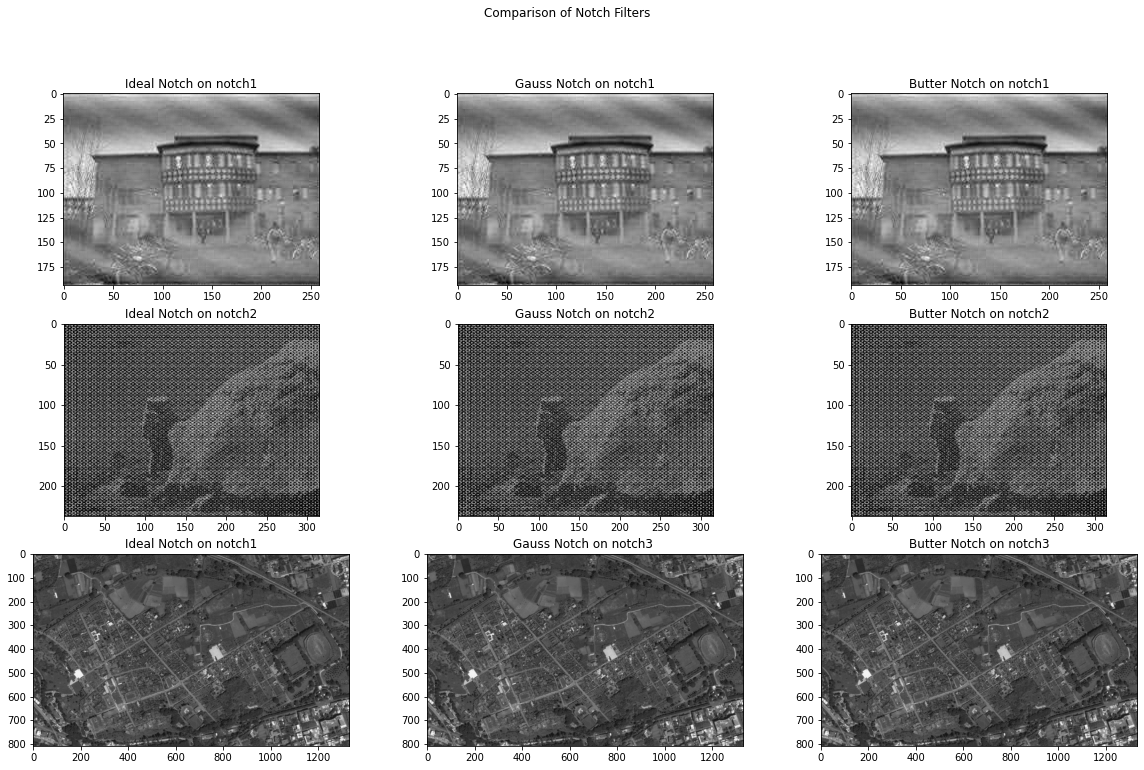

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (20,12))
axs[0,0].imshow(notch_denoise(notch1), cmap = 'gray')
axs[0,0].set_title("Ideal Notch on notch1")

axs[0,1].imshow(gauss_notch(notch1), cmap = 'gray')
axs[0,1].set_title("Gauss Notch on notch1")

axs[0,2].imshow(butter_notch(notch1), cmap = 'gray')
axs[0,2].set_title("Butter Notch on notch1")

axs[1,0].imshow(notch_denoise(notch2), cmap = 'gray')
axs[1,0].set_title("Ideal Notch on notch2")

axs[1,1].imshow(gauss_notch(notch2), cmap = 'gray')
axs[1,1].set_title("Gauss Notch on notch2")

axs[1,2].imshow(butter_notch(notch2), cmap = 'gray')
axs[1,2].set_title("Butter Notch on notch2")

axs[2,0].imshow(notch_denoise(notch3), cmap = 'gray')
axs[2,0].set_title("Ideal Notch on notch1")

axs[2,1].imshow(gauss_notch(notch3), cmap = 'gray')
axs[2,1].set_title("Gauss Notch on notch3 ")

axs[2,2].imshow(butter_notch(notch3), cmap = 'gray')
axs[2,2].set_title("Butter Notch on notch3")

fig.suptitle("Comparison of Notch Filters")

#3.

In [ ]:
def plot_hist(img_path):
    img = cv2.imread(img_path)
    fig, axs = plt.subplots(1,2, figsize = (9,5))
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title(f'original {img_path}')

    axs[1].hist(img.ravel(),256,[0,256], color = 'g')
    axs[1].set_title(f'Histogram of {img_path}')
    return

## Histogram of images

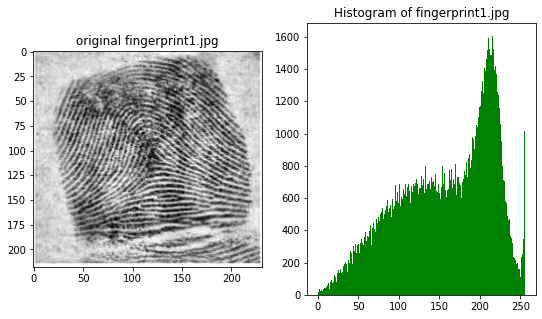

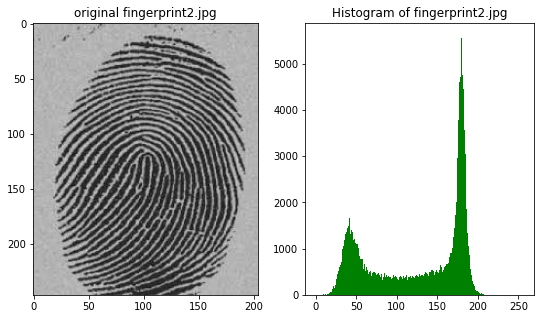

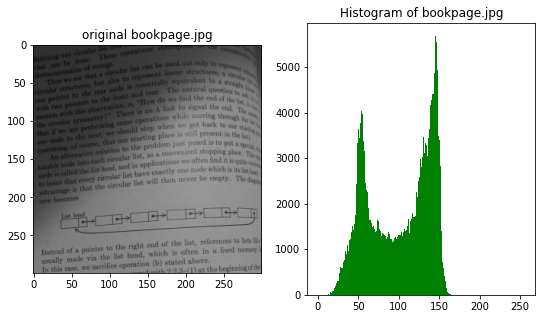

In [ ]:
imgs = ['fingerprint1.jpg', 'fingerprint2.jpg', 'bookpage.jpg']
for img in imgs:
    plot_hist(img)

##Global Thresholding

In [ ]:
from IPython.core.pylabtools import figsize
def global_thresh(img_path):
    img = cv2.imread(img_path, 0)
    thresholds = [0, 100, 150, 200]
    fig, axs = plt.subplots(5,2, figsize = (30,15))
    fig.set_figheight(18)
    fig.set_figwidth(10)
    axs[0,0].imshow(img, cmap = 'gray')
    axs[0,0].set_title('Original Image')

    axs[0,1].hist(img.ravel(), 256, (0,256), color = 'r')
    axs[0,1].set_title('histogram of the original image')

    for t in range(len(thresholds)):
        _, thres = cv2.threshold(img, thresholds[t], 256, cv2.THRESH_BINARY)
        axs[t+1,0].imshow(thres, cmap = 'gray')
        axs[t+1,0].set_title(f'image with thresholding at {thresholds[t]}')

        axs[t+1,1].hist(thres.ravel(), 256, (0,256), color = 'b')
        axs[t+1,1].set_title(f'histogram after thresholding at {thresholds[t]}')

    fig.suptitle('Global Thresholding', size = 15)
    plt.show()
    return

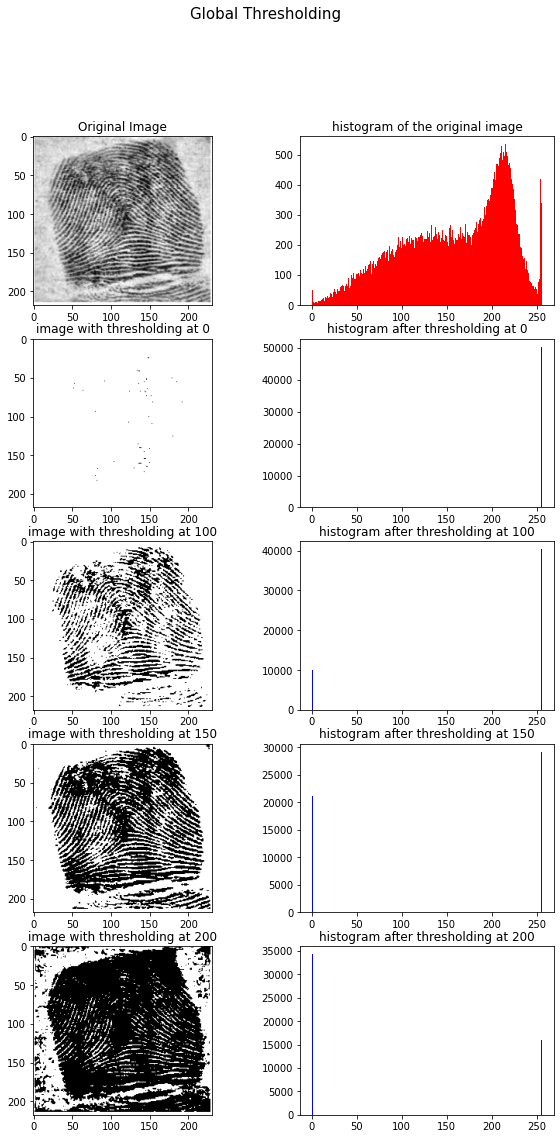

In [ ]:
global_thresh(imgs[0])

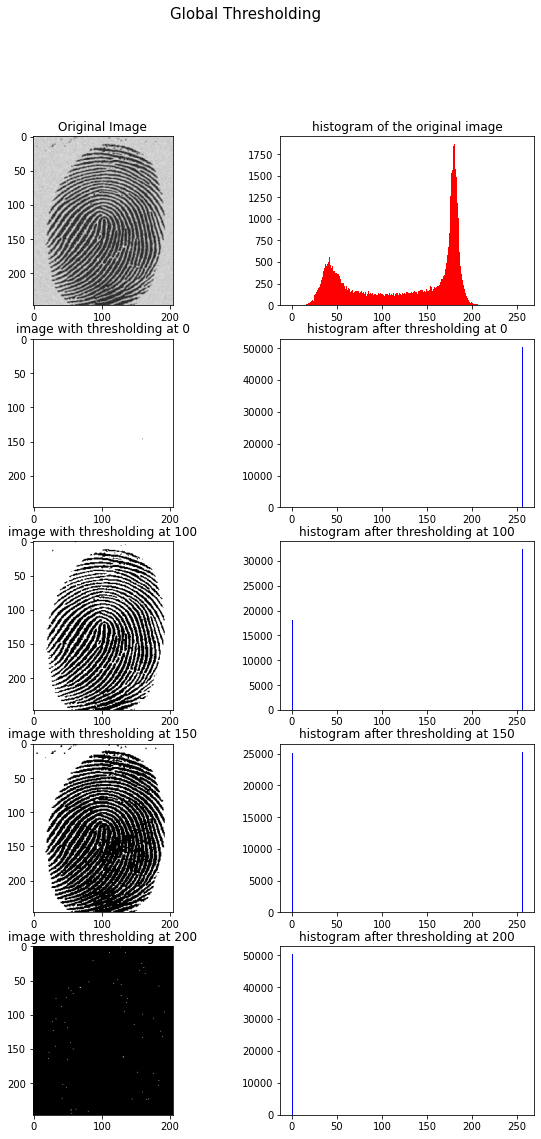

In [ ]:
global_thresh(imgs[1])

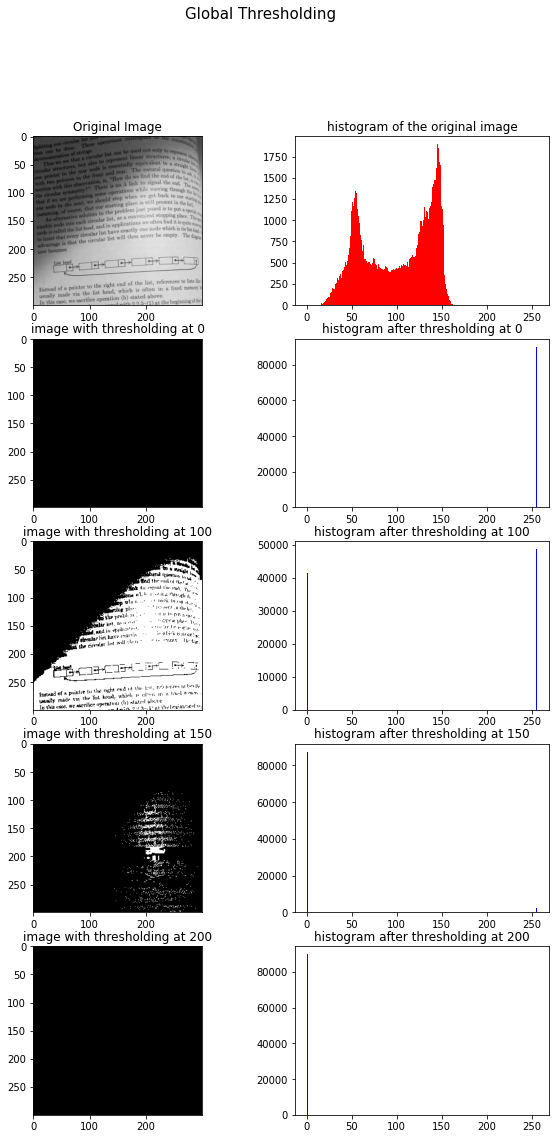

In [ ]:
global_thresh(imgs[2])

##Otsu Threshold

In [ ]:
from IPython.core.pylabtools import figsize
def otsu_thresh(img_path):
    img = cv2.imread(img_path, 0)
    thresholds = [0, 100, 150, 200]
    fig, axs = plt.subplots(5,2, figsize = (30,15))
    fig.set_figheight(18)
    fig.set_figwidth(10)
    axs[0,0].imshow(img, cmap = 'gray')
    axs[0,0].set_title('Original Image')

    axs[0,1].hist(img.ravel(), 256, (0,256), color = 'r')
    axs[0,1].set_title('histogram of the original image')

    for t in range(len(thresholds)):
        ret2,thres = cv2.threshold(img,t,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        axs[t+1,0].imshow(thres, cmap = 'gray')
        axs[t+1,0].set_title(f'image with thresholding at {thresholds[t]}')

        axs[t+1,1].hist(thres.ravel(), 256, (0,256), color = 'b')
        axs[t+1,1].set_title(f'histogram after thresholding at {thresholds[t]}')

    fig.suptitle('Otsu Thresholding', size = 15)
    plt.show()
    return

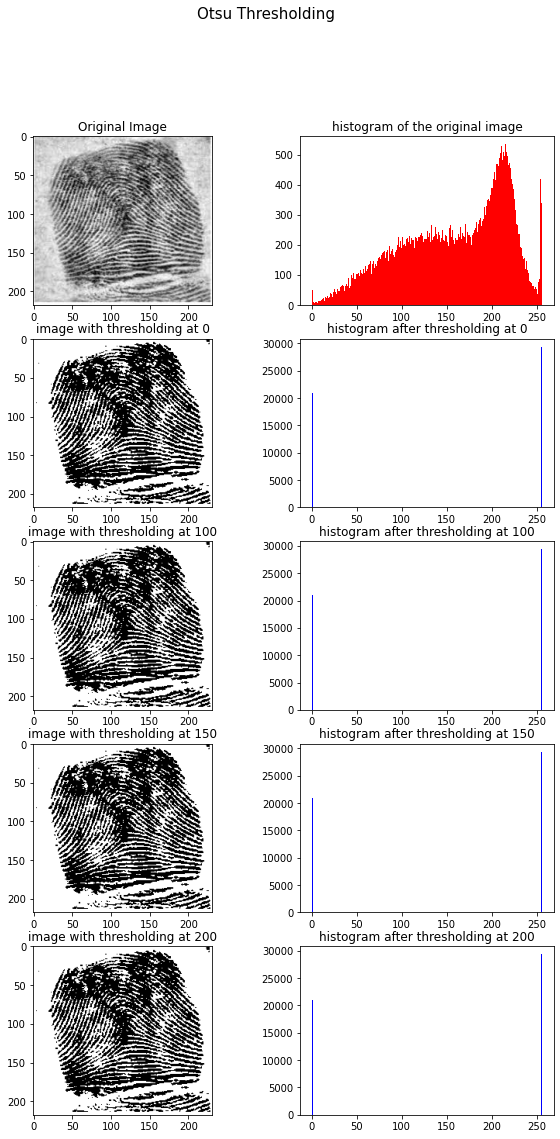

In [ ]:
otsu_thresh(imgs[0])

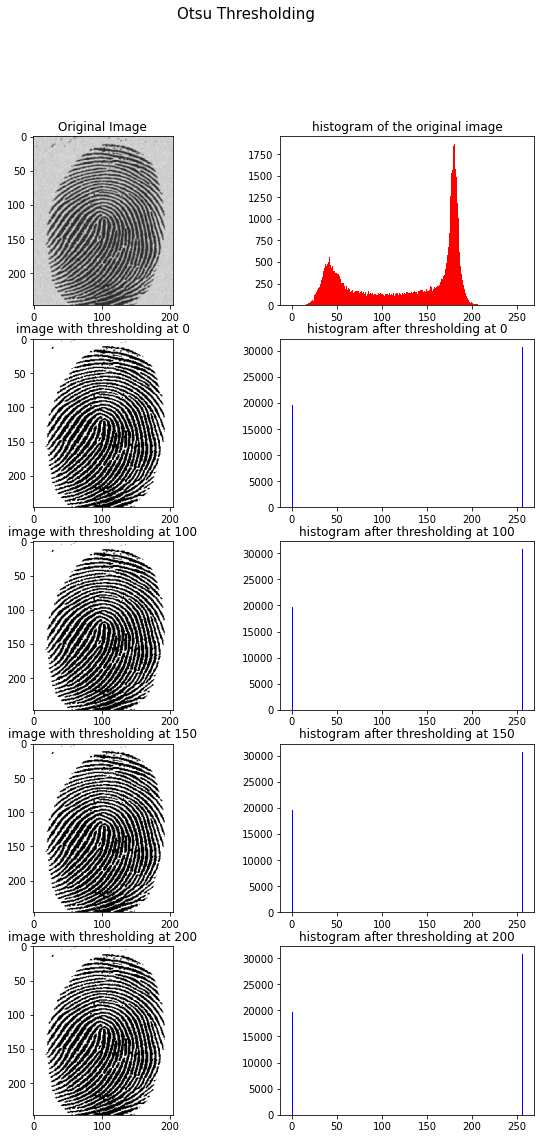

In [ ]:
otsu_thresh(imgs[1])

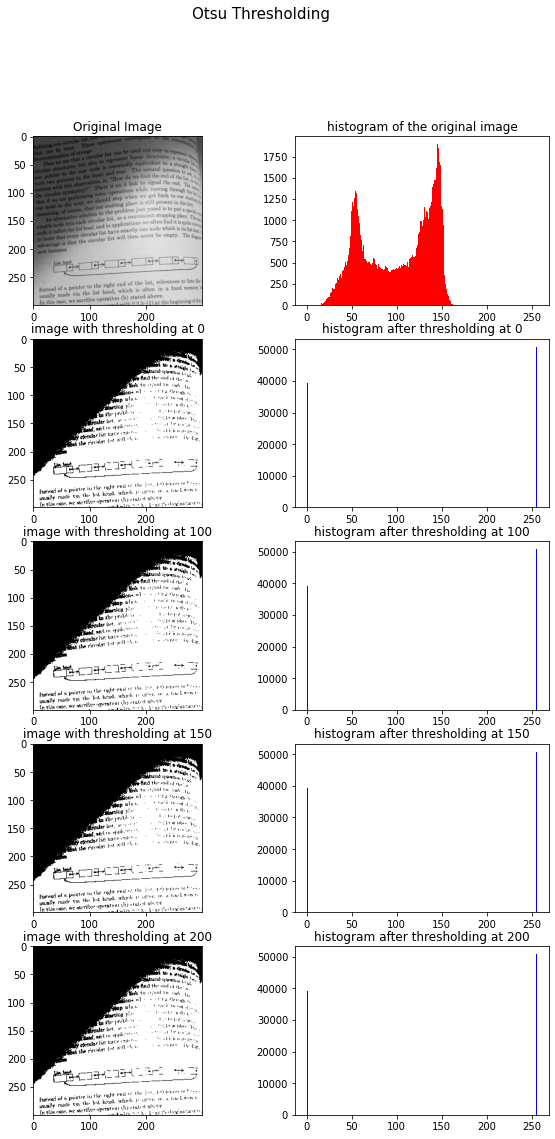

In [ ]:
otsu_thresh(imgs[2])

In [ ]:
from IPython.core.pylabtools import figsize
def adaptive_mean_thresh(img_path):
    img = cv2.imread(img_path, 0)
    thresholds = [0, 100, 150, 200]
    fig, axs = plt.subplots(2,2, figsize = (30,15))
    fig.set_figheight(18)
    fig.set_figwidth(10)
    axs[0,0].imshow(img, cmap = 'gray')
    axs[0,0].set_title('Original Image')

    axs[0,1].hist(img.ravel(), 256, (0,256), color = 'r')
    axs[0,1].set_title('histogram of the original image')

        
    thres = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)


    axs[1,0].imshow(thres, cmap = 'gray')
    axs[1,0].set_title(f'image with thresholding')

    axs[1,1].hist(thres.ravel(), 256, (0,256), color = 'b')
    axs[1,1].set_title(f'histogram after thresholding')

    fig.suptitle('Addaptive Mean Thresholding', size = 15)
    plt.show()
    return

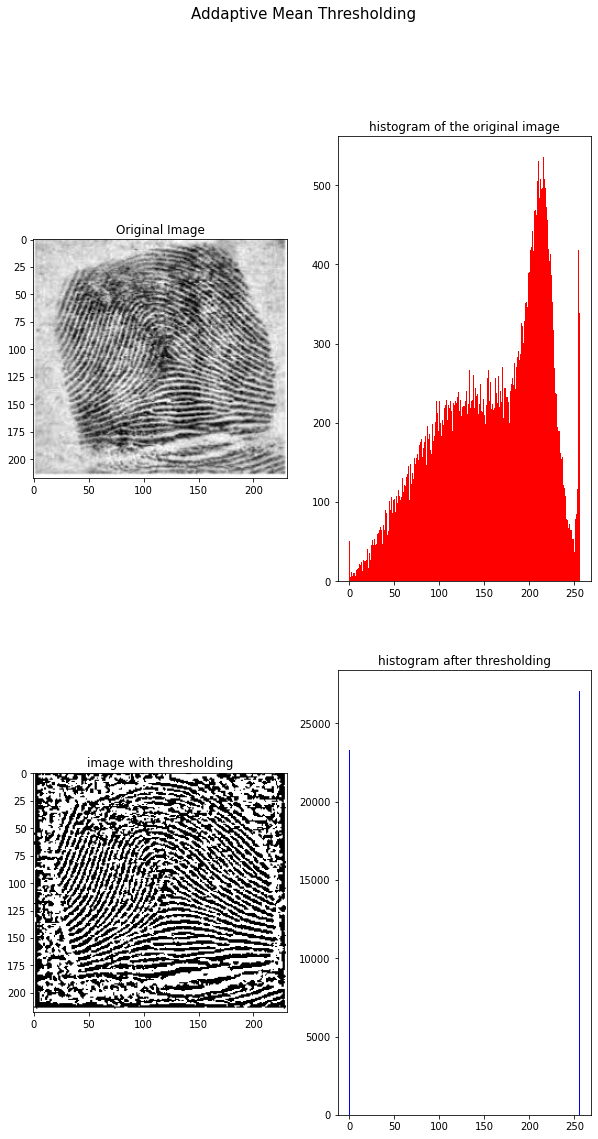

In [ ]:
adaptive_mean_thresh(imgs[0])

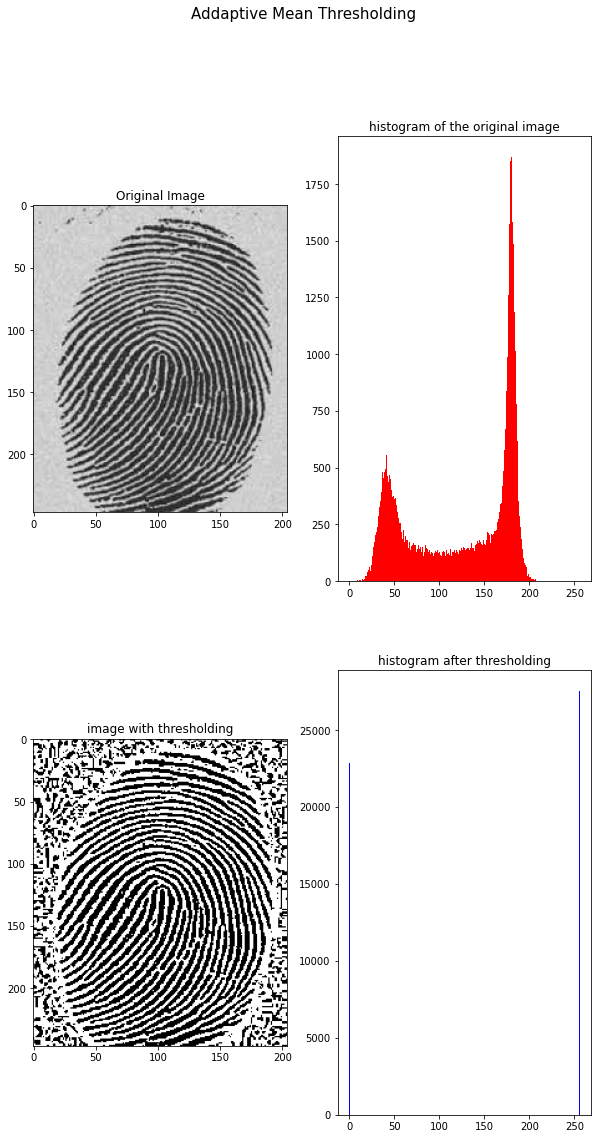

In [ ]:
adaptive_mean_thresh(imgs[1])

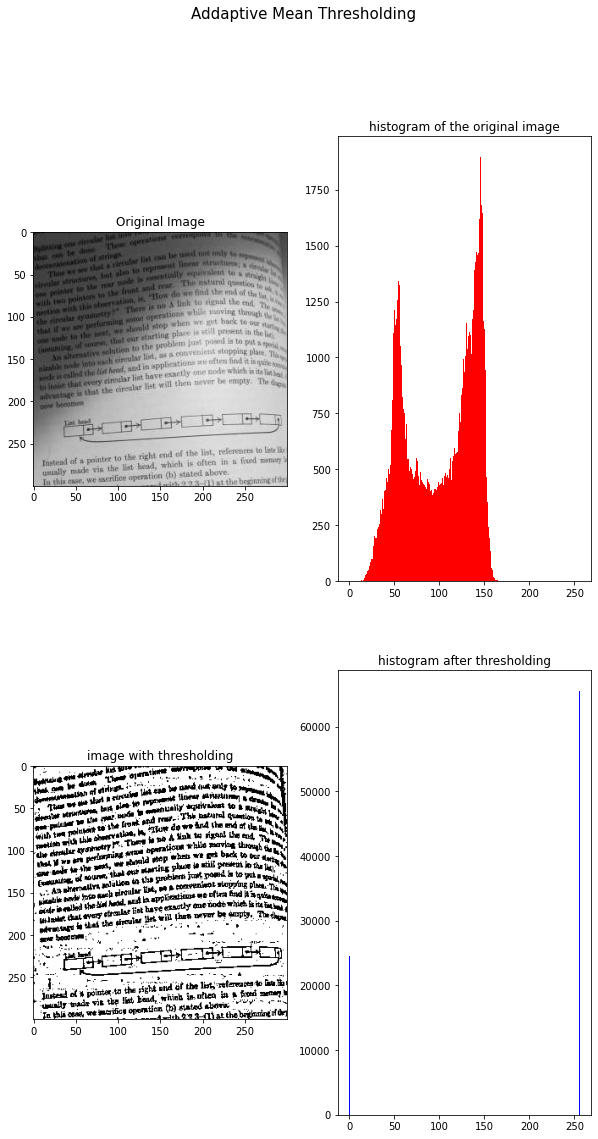

In [ ]:
adaptive_mean_thresh(imgs[2])

In [ ]:
from IPython.core.pylabtools import figsize
def adaptive_gaussian_thresh(img_path):
    img = cv2.imread(img_path, 0)
    thresholds = [0, 100, 150, 200]
    fig, axs = plt.subplots(2,2, figsize = (30,15))
    fig.set_figheight(18)
    fig.set_figwidth(10)
    axs[0,0].imshow(img, cmap = 'gray')
    axs[0,0].set_title('Original Image')

    axs[0,1].hist(img.ravel(), 256, (0,256), color = 'r')
    axs[0,1].set_title('histogram of the original image')

        
    thres = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)


    axs[1,0].imshow(thres, cmap = 'gray')
    axs[1,0].set_title(f'image with thresholding')

    axs[1,1].hist(thres.ravel(), 256, (0,256), color = 'b')
    axs[1,1].set_title(f'histogram after thresholding')

    fig.suptitle('Adaptive Gaussian Thresholding', size = 15)
    plt.show()
    return

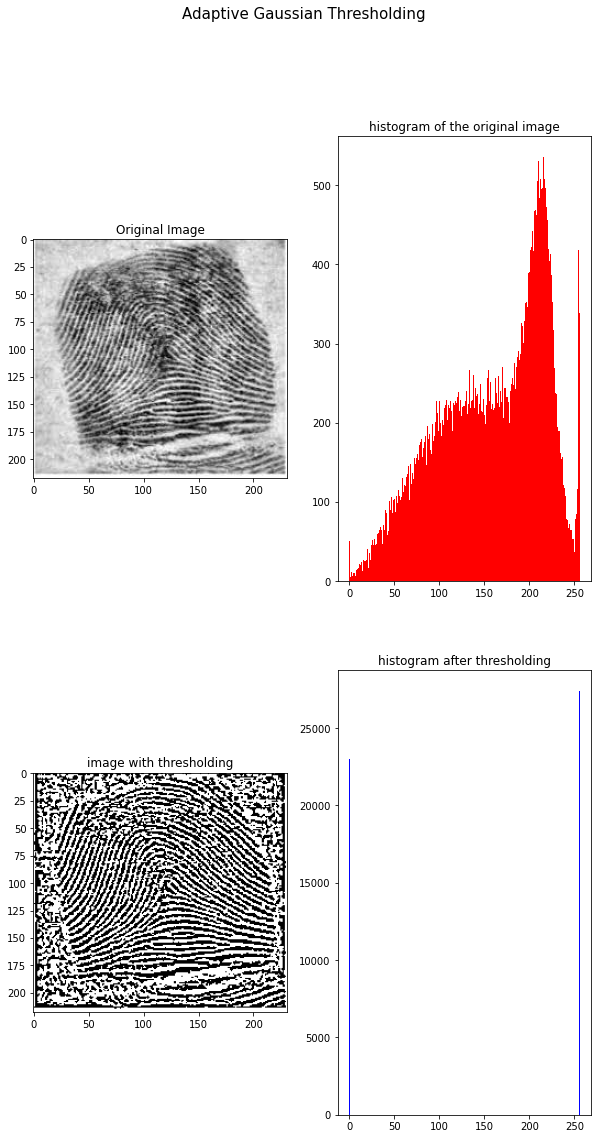

In [ ]:
adaptive_gaussian_thresh(imgs[0])

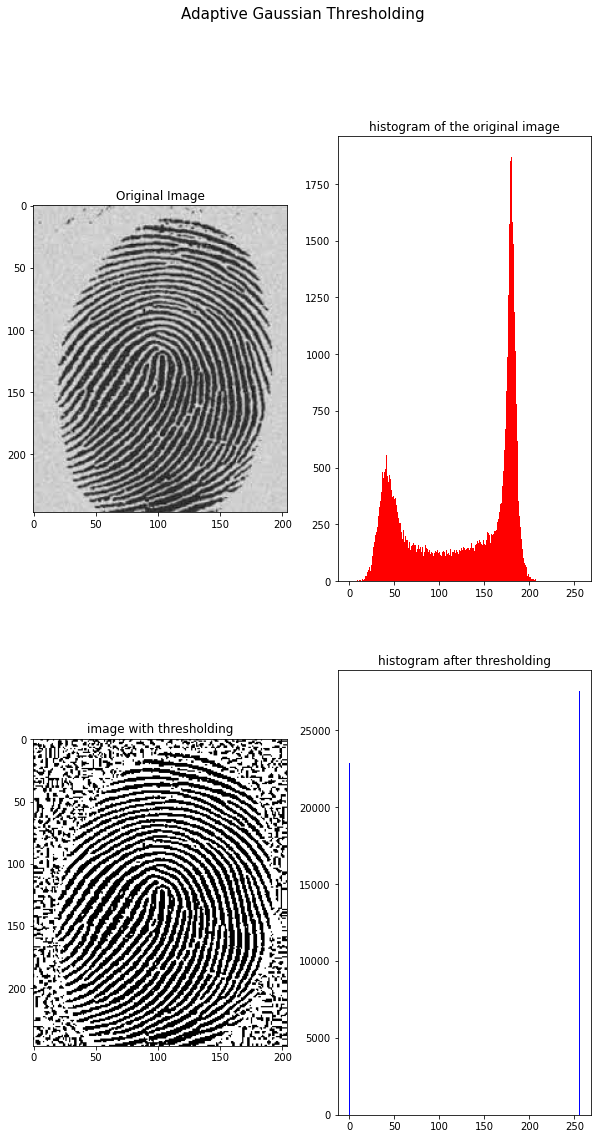

In [ ]:
adaptive_gaussian_thresh(imgs[1])

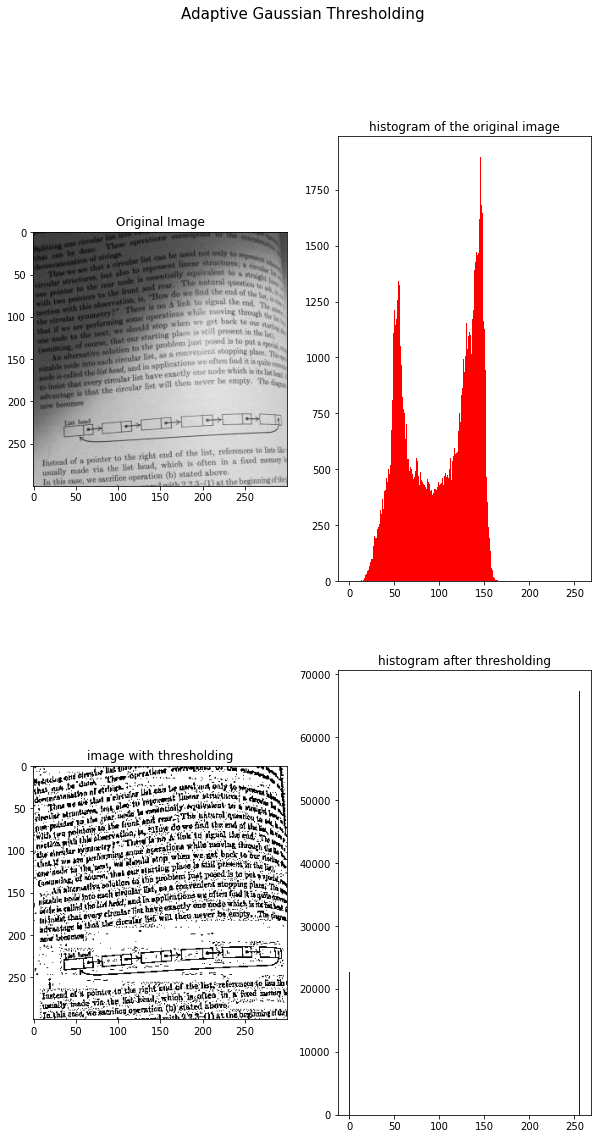

In [ ]:
adaptive_gaussian_thresh(imgs[2])

From the above results we conclude that for the images `fingerprint1.jpg` and `fingerprint2.jpg`, global thresholding method and Otsu's method have worked better than adaptive thresholding methods, with Otsu's method providing better results than global thresholding.

For the image `bookpage.jpg`, the adaptive thresolding methods (both mean and Gaussian) is working better than the other methods we applied.